In [146]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 18})

In [147]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

In [148]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
hdul = fits.open(FITS1)
# print(hdul.info())
MapStokesI = hdul[0]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngle = hdul[11]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]


MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()

######## taking points only with singal to noise ratio more than 2
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data
Selector = (MapPolSNR.data < 3)

BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan

############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()



/tmp/ipykernel_42023/3980308418.py:19: RuntimeWarning: Mean of empty slice
  S_v2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5


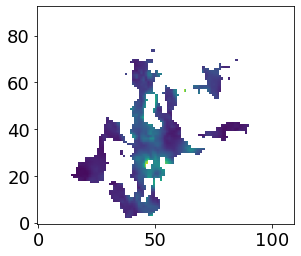

In [149]:

set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
S_map_v2 = BlankedMapPolAngle.copy()
for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

       
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S_v2 = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map_v2.data[i,j] = S_v2

plt.figure()
plt.imshow(S_map_v2.data,origin='lower')
plt.show()

In [150]:
# def line_1(x, y):
#     top_x = 309.9258719
#     top_y = 42.4556451
#     bottom_x = 309.7452960
#     bottom_y =   42.4556451
#     slope = (top_y - bottom_y)/(top_x-bottom_x)
#     return (y-top_y) - slope*(x-top_x)

# def line_2(x, y):
#     top_x = 309.7452960
#     top_y = 42.4556451
#     bottom_x = 309.7504553
#     bottom_y =  42.4380577
#     slope = (top_y - bottom_y)/(top_x-bottom_x)
#     return (y-top_y) - slope*(x-top_x)

# def line_3(x, y):
#     top_x = 309.7504553
#     top_y = 42.4380577
#     bottom_x = 309.7366984
#     bottom_y =  42.4237862
#     slope = (top_y - bottom_y)/(top_x-bottom_x)
#     return (y-top_y) - slope*(x-top_x)

# def line_4(x, y):
#     top_x = 309.7366984
#     top_y = 42.4237862
#     bottom_x = 309.7086503
#     bottom_y =  42.3137186
#     slope = (top_y - bottom_y)/(top_x-bottom_x)
#     return (y-top_y) - slope*(x-top_x)



# I_ridge = BlankedMapStokesI.copy()
# p_ridge = BlankedMapPol.copy()
# s_ridge = S_map_v2.copy()


# I_fill = BlankedMapStokesI.copy()
# p_fill = BlankedMapPol.copy()
# s_fill = S_map_v2.copy()

# selector = ((line_1(RA_grid,DEC_grid)>0) + (line_4(RA_grid,DEC_grid)>0)) + (line_2(RA_grid,DEC_grid)<0)*(line_3(RA_grid,DEC_grid)>0)
# #  + (line_2(RA_grid,DEC_grid)<0)*(line_3(RA_grid,DEC_grid)>0))
# # selector = (line_1(RA_grid,DEC_grid)>0)*(line_2(RA_grid,DEC_grid)<0)*(line_3(RA_grid,DEC_grid)>0)
# I_ridge.data[selector] = np.nan
# p_ridge.data[selector] = np.nan
# s_ridge.data[selector] = np.nan

# selector = ~selector

# # selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)>0)*(line_3(RA_grid,DEC_grid)<0)
# I_fill.data[selector] = np.nan
# p_fill.data[selector] = np.nan
# s_fill.data[selector] = np.nan



# fig = plt.subplots(figsize =(30, 10))
# ax1 = plt.subplot(131)
# ax1.imshow(np.log(BlankedMapStokesI.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region intensity')
# ax2 = plt.subplot(132)
# ax2.imshow(np.log(I_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('regions with intensity in the ridge region')
# ax3 = plt.subplot(133)
# ax3.imshow(np.log(I_fill.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('regions with intensity in the fillament region')
# plt.show()

# fig = plt.subplots(figsize =(30, 10))
# ax1 = plt.subplot(131)
# ax1.imshow(BlankedMapPol.data,origin='lower')
# ax1.set_title('whole region Pfrac')
# ax2 = plt.subplot(132)
# ax2.imshow(p_ridge.data,origin = 'lower',vmin=0,vmax = 100)
# ax2.set_title('Pfrac regions with intensity in the ridge region')
# ax3 = plt.subplot(133)
# ax3.imshow(p_fill.data,origin = 'lower',vmin=0,vmax = 100)
# ax3.set_title('Pfrac regions with intensity in the fillament region')
# plt.show()

# fig = plt.subplots(figsize =(30, 10))
# ax1 = plt.subplot(131)
# ax1.imshow(S_map_v2.data,origin='lower',vmin=0,vmax = 90)
# ax1.set_title('whole region angle dispersion')
# ax2 = plt.subplot(132)
# ax2.imshow(s_ridge.data,origin = 'lower',vmin=0,vmax = 90)
# ax2.set_title('angle dispersion regions with intensity in the ridge region')
# ax3 = plt.subplot(133)
# ax3.imshow(s_fill.data,origin = 'lower')
# ax3.set_title('angle dispersion regions with intensity in the fillament region')
# plt.show()

In [151]:
# def lin_fit(x, a, b):
#     return a + b*x

# s_ridge_array = s_ridge.data.flatten()
# p_ridge_array = p_ridge.data.flatten()
# I_ridge_array = I_ridge.data.flatten()


# log_s = np.log(s_ridge_array)
# log_p = np.log(p_ridge_array)
# log_I = np.log(I_ridge_array)


# p_min = np.nanmin(log_p)
# p_max = np.log(50)
# s_min = np.nanmin(log_s)
# s_max = np.nanmax(log_s)
# I_min = np.nanmin(log_I)
# I_max = np.nanmax(log_I)
  

# p_bins = np.arange(p_min, p_max, 0.075)
# s_bins = np.arange(s_min, s_max, 0.075)
# I_bins = np.arange(I_min, I_max, 0.075)

# df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
# df_log = df_log.dropna()

# PS_upper_param, PS_upper_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
# PS_FitFunc_upper = lin_fit(s_bins,PS_upper_param[0],PS_upper_param[1])
# # print(PS_upper_param[0],PS_upper_param[1])

# PI_upper_param, PI_upper_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
# PI_FitFunc_upper = lin_fit(I_bins,PI_upper_param[0],PI_upper_param[1])
# # print(PI_upper_param[0],PI_upper_param[1])

# fig = plt.subplots(figsize =(30, 15))
# ax1 = plt.subplot(122)
# ax1.hist2d(log_s,log_p,bins =[s_bins, p_bins])
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_upper_param[1],C = PS_upper_param[0],linebreak='\n')
# plt.plot(s_bins,PS_FitFunc_upper,'r',linewidth=3,label = label_temp)
# ax1.set_title("log p X log S 2D histogram")
# ax1.set_ylabel('log p ')
# ax1.set_xlabel('log S ')
# # ax1.set_xlim(-1,5,5)
# # ax1.set_ylim(-2.5,4)
# ax2 = plt.subplot(121)
# ax2.hist2d(log_I,log_p,bins =[I_bins, p_bins])
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_upper_param[1],C = PI_upper_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_upper,'r',linewidth=3,label = label_temp)
# ax2.set_title("log p X log I 2D histogram")
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')
# # ax2.set_xlim(-1,5,5)
# # ax2.set_ylim(-2.5,4)
# plt.tight_layout()
# ax1.legend()
# ax2.legend()
# plt.show()

# def DoubleParamFunc(X, a, b, c):
#     x,y = X
#     return a + b*x + c*y

# p0 = -0.5539, -0.2614, 2.
# PSI_param_upper, PSI_param_cov_upper = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print(PSI_param_upper)

   

In [152]:
# def lin_fit(x, a, b):
#     return a + b*x

# s_fill_array = s_fill.data.flatten()
# p_fill_array = p_fill.data.flatten()
# I_fill_array = I_fill.data.flatten()


# log_s = np.log(s_fill_array)
# log_p = np.log(p_fill_array)
# log_I = np.log(I_fill_array)


# p_min = np.nanmin(log_p)
# p_max = np.log(50)
# s_min = np.nanmin(log_s)
# s_max = np.nanmax(log_s)
# I_min = np.nanmin(log_I)
# I_max = np.nanmax(log_I)
  

# p_bins = np.arange(p_min, p_max, 0.075)
# s_bins = np.arange(s_min, s_max, 0.075)
# I_bins = np.arange(I_min, I_max, 0.075)

# df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
# df_log = df_log.dropna()

# PS_lower_param, PS_lower_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
# PS_FitFunc_lower = lin_fit(s_bins,PS_lower_param[0],PS_lower_param[1])
# # print(PS_lower_param[0],PS_lower_param[1])

# PI_upper_param, PI_upper_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
# PI_FitFunc_lower = lin_fit(I_bins,PI_upper_param[0],PI_upper_param[1])
# # print(PI_upper_param[0],PI_upper_param[1])

# fig = plt.subplots(figsize =(30, 15))
# ax1 = plt.subplot(122)
# ax1.hist2d(log_s,log_p,bins =[s_bins, p_bins])
# label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_upper_param[1],C = PS_upper_param[0],linebreak='\n')
# plt.plot(s_bins,PS_FitFunc_lower,'r',linewidth=3,label = label_temp)
# ax1.set_title("log p X log S 2D histogram")
# ax1.set_ylabel('log p ')
# ax1.set_xlabel('log S ')
# # ax1.set_xlim(-1,5,5)
# # ax1.set_ylim(-2.5,4)
# ax2 = plt.subplot(121)
# ax2.hist2d(log_I,log_p,bins =[I_bins, p_bins])
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_upper_param[1],C = PI_upper_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_lower,'r',linewidth=3,label = label_temp)
# ax2.set_title("log p X log I 2D histogram")
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')
# # ax2.set_xlim(-1,5,5)
# # ax2.set_ylim(-2.5,4)
# plt.tight_layout()
# ax1.legend()
# ax2.legend()
# plt.show()

# def DoubleParamFunc(X, a, b, c):
#     x,y = X
#     return a + b*x + c*y

# p0 = -0.5539, -0.2614, 2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print(PSI_param_lower)

In [153]:
# def lin_fit(x, a, b):
#     return a + b*x

# def S_seperator(x, y):
#     top_x = 3.800
#     top_y = 3.445
#     bottom_x = 1.421
#     bottom_y =  1.337
#     slope = (top_y - bottom_y)/(top_x-bottom_x)
#     return (y-top_y) - slope*(x-top_x)

# s_ridge_array = s_ridge.data.flatten()
# p_ridge_array = p_ridge.data.flatten()
# I_ridge_array = I_ridge.data.flatten()



# log_s = np.log(s_ridge_array)
# log_p = np.log(p_ridge_array)
# log_I = np.log(I_ridge_array)


# p_min = np.nanmin(log_p)
# p_max = np.log(50)
# s_min = np.nanmin(log_s)
# s_max = np.nanmax(log_s)
# I_min = np.nanmin(log_I)
# I_max = np.nanmax(log_I)
  

# p_bins = np.arange(p_min, p_max, 0.075)
# s_bins = np.arange(s_min, s_max, 0.075)
# I_bins = np.arange(I_min, I_max, 0.075)

# df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
# df_log = df_log.dropna()

# df_upper_s = df_log[S_seperator(df_log['logs'],df_log['logp'])>0]
# df_lower_s = df_log[S_seperator(df_log['logs'],df_log['logp'])<0]


# PS_ridge_param_upper, PS_ridge_param_cov_upper = curve_fit(lin_fit, df_upper_s['logs'], df_upper_s['logp'])
# PS_FitFunc_ridge_upper = lin_fit(s_bins,PS_ridge_param_upper[0],PS_ridge_param_upper[1])
# # print(PS_upper_param[0],PS_upper_param[1])

# PS_ridge_param_lower, PS_ridge_param_cov_lower = curve_fit(lin_fit, df_lower_s['logs'], df_lower_s['logp'])
# PS_FitFunc_ridge_lower = lin_fit(s_bins,PS_ridge_param_lower[0],PS_ridge_param_lower[1])
# # print(PS_upper_param[0],PS_upper_param[1])


# PI_ridge_param, PI_ridge_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
# PI_FitFunc_ridge = lin_fit(I_bins,PI_ridge_param[0],PI_ridge_param[1])
# # print(PI_upper_param[0],PI_upper_param[1])

# fig = plt.subplots(figsize =(30, 15))
# ax1 = plt.subplot(122)
# ax1.hist2d(log_s,log_p,bins =[s_bins, p_bins])
# label_temp_upper = r'upper population {linebreak} log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param_upper[1],C = PS_ridge_param_upper[0],linebreak='\n')
# plt.plot(s_bins,PS_FitFunc_ridge_upper,'r',linewidth=3,label = label_temp_upper)
# label_temp_lower = r'lower population {linebreak} log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param_lower[1],C = PS_ridge_param_lower[0],linebreak='\n')
# plt.plot(s_bins,PS_FitFunc_ridge_lower,'y',linewidth=3,label = label_temp_lower)
# ax1.set_title("log p X log S 2D histogram")
# ax1.set_ylabel('log p ')
# ax1.set_xlabel('log S ')
# ax2 = plt.subplot(121)
# ax2.hist2d(log_I,log_p,bins =[I_bins, p_bins])
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax2.set_title("log p X log I 2D histogram")
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')
# plt.tight_layout()
# ax1.legend()
# ax2.legend()
# plt.show()

# # def DoubleParamFunc(X, a, b, c):
# #     x,y = X
# #     return a + b*x + c*y

# # p0 = -0.5539, -0.2614, 2.
# # PSI_param_upper, PSI_param_cov_upper = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# # print(PSI_param_upper)

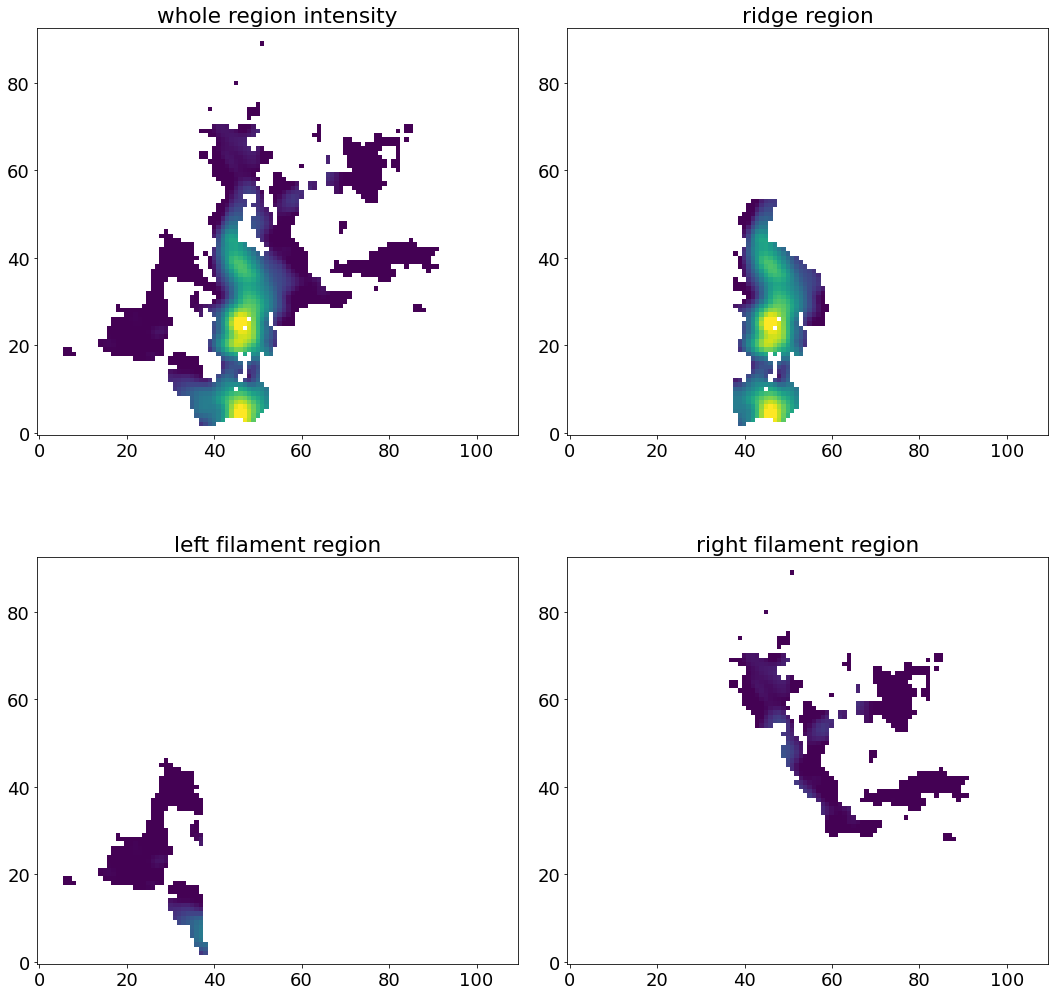

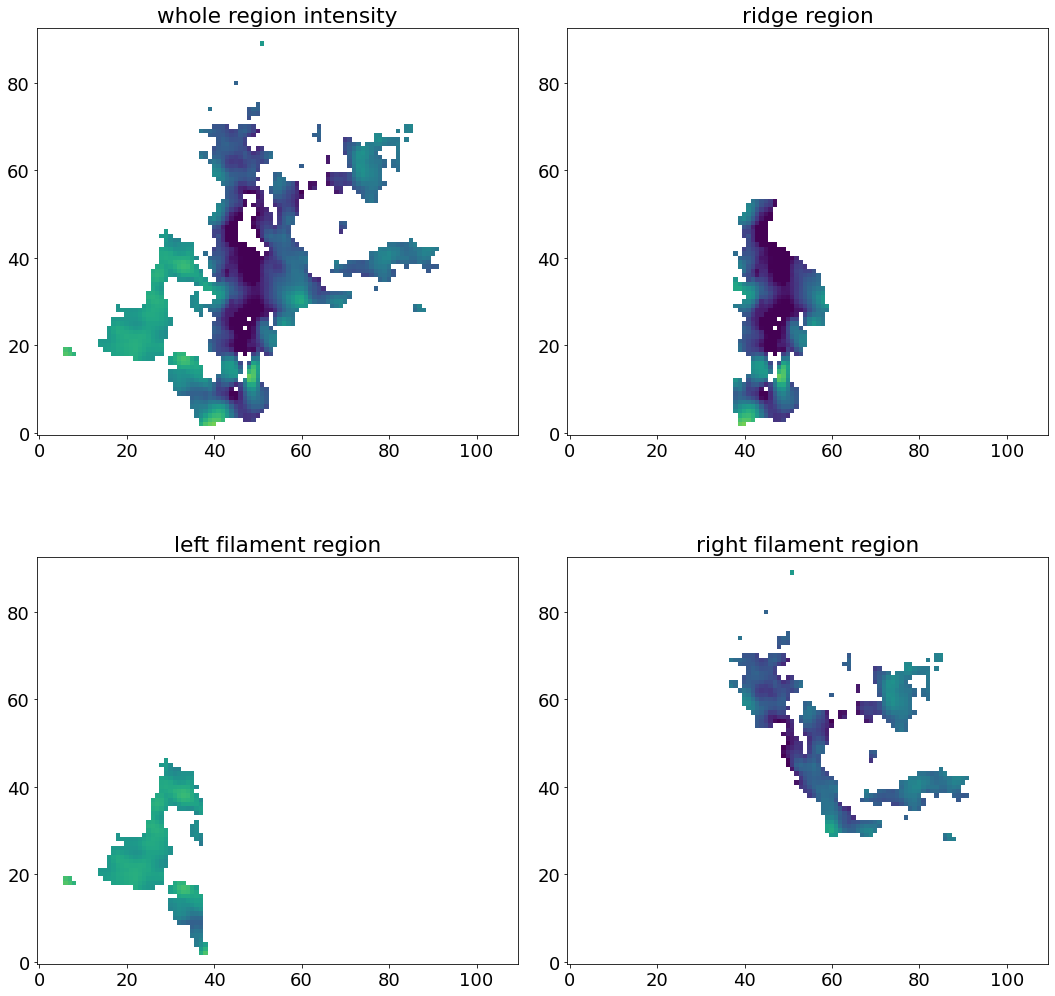

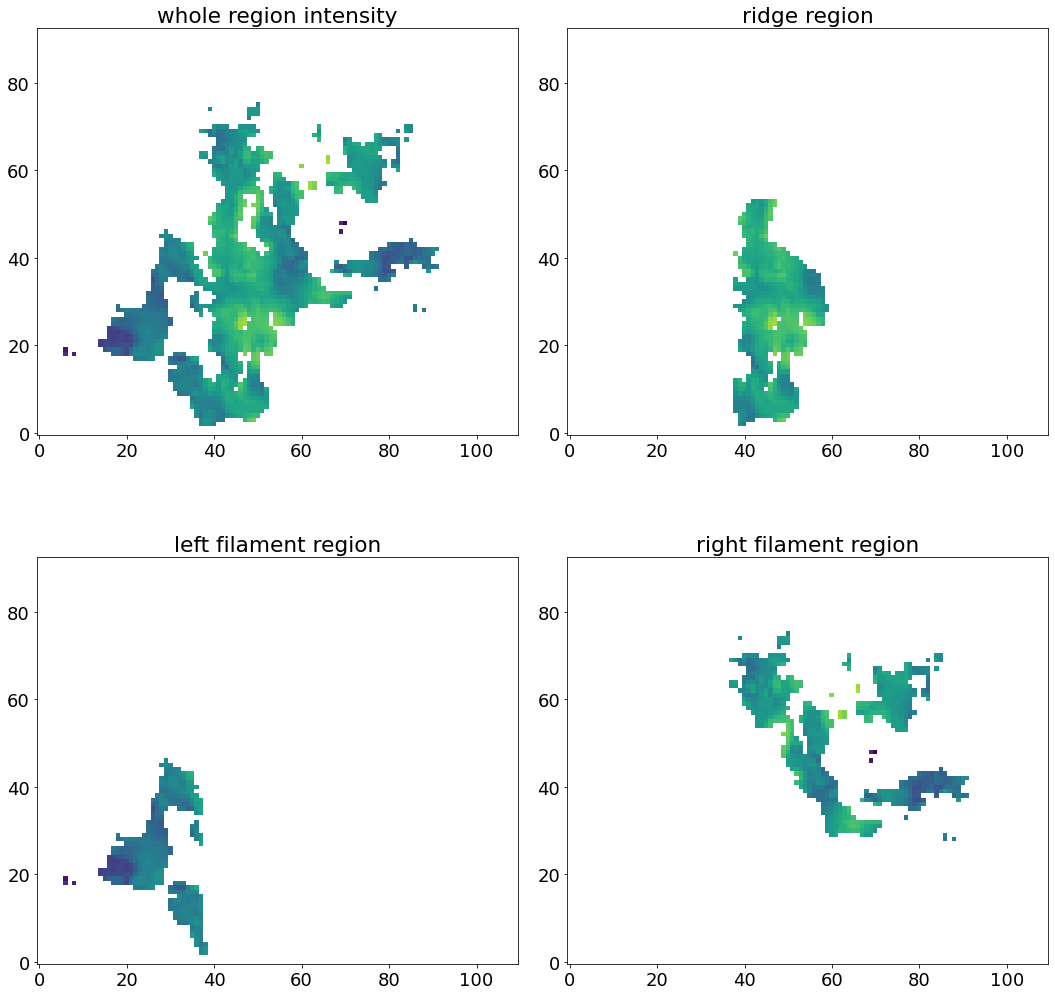

In [154]:
def line_1(x, y):
    top_x = 309.9258719
    top_y = 42.4556451
    bottom_x = 309.7452960
    bottom_y =   42.4556451
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_2(x, y):
    top_x = 309.7838598
    top_y = 42.4569364
    bottom_x = 309.7792727
    bottom_y =  42.3127837
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_3(x, y):
    top_x = 309.7468561
    top_y = 42.4529922
    bottom_x = 309.7507272
    bottom_y =  42.4299500
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_4(x, y):
    top_x = 309.7507272
    top_y = 42.4305231
    bottom_x = 309.7108001
    bottom_y =  42.4094674
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_5(x, y):
    top_x = 309.7108001
    top_y = 42.4094674
    bottom_x = 309.699191
    bottom_y =  42.3710874
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

I_ridge_plus_fill_right= BlankedMapStokesI.copy()
p_ridge_plus_fill_right = BlankedMapPol.copy()
s_ridge_plus_fill_right = S_map_v2.copy()

I_fil_left = BlankedMapStokesI.copy()
p_fil_left = BlankedMapPol.copy()
s_fil_left = S_map_v2.copy()

selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)<0)
I_ridge_plus_fill_right.data[selector] = np.nan
p_ridge_plus_fill_right.data[selector] = np.nan
s_ridge_plus_fill_right.data[selector] = np.nan


selector = ~selector
I_fil_left.data[selector] = np.nan
p_fil_left.data[selector] = np.nan
s_fil_left.data[selector] = np.nan


I_fil_right = I_ridge_plus_fill_right.copy()
p_fil_right = p_ridge_plus_fill_right.copy()
s_fil_right = s_ridge_plus_fill_right.copy()

I_ridge = I_ridge_plus_fill_right.copy()
p_ridge = p_ridge_plus_fill_right.copy()
s_ridge = s_ridge_plus_fill_right.copy()

selector = (line_1(RA_grid,DEC_grid)>0)+ (line_3(RA_grid,DEC_grid)<0)*(line_4(RA_grid,DEC_grid)>0) + (line_5(RA_grid,DEC_grid)>0)
  
I_ridge.data[selector] = np.nan
p_ridge.data[selector] = np.nan
s_ridge.data[selector] = np.nan


selector = ~selector
I_fil_right.data[selector] = np.nan
p_fil_right.data[selector] = np.nan
s_fil_right.data[selector] = np.nan


fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapStokesI.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region intensity')
ax2 = plt.subplot(222)
ax2.imshow(np.log(I_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(I_fil_left.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('left filament region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(I_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapPol.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region intensity')
ax2 = plt.subplot(222)
ax2.imshow(np.log(p_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(p_fil_left.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('left filament region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(p_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(S_map_v2.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region intensity')
ax2 = plt.subplot(222)
ax2.imshow(np.log(s_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(s_fil_left.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('left filament region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(s_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('right filament region')
plt.tight_layout()
plt.show()


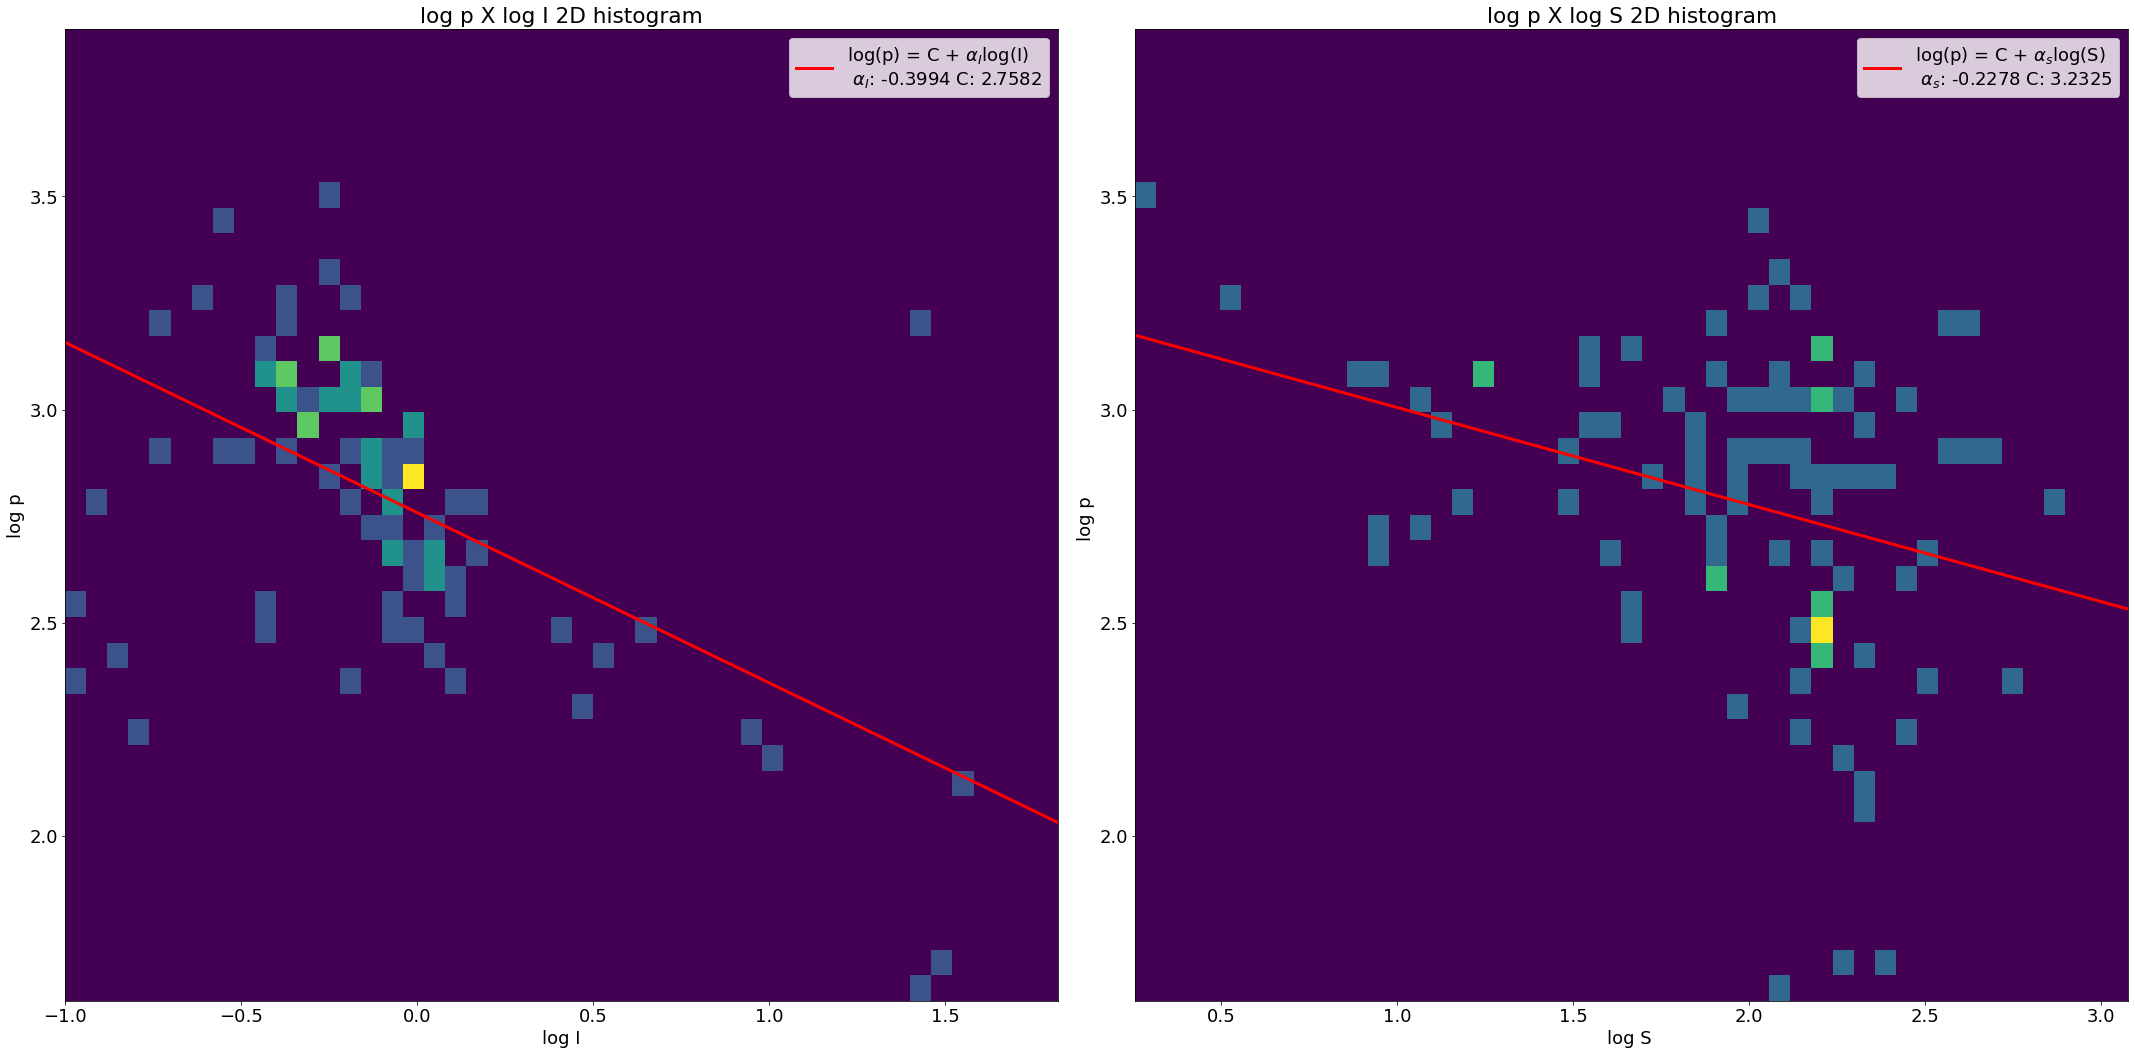

C : 3.178429132808627
s index : -0.21172545423946332
p index : -0.39207094320565095


In [184]:
def lin_fit(x, a, b):
    return a + b*x

s_fill_left_array = s_fil_left.data.flatten()
p_fill_left_array = p_fil_left.data.flatten()
I_fill_left_array = I_fil_left.data.flatten()

s_fill_left_array_ind = s_fill_left_array.copy()
s_fill_left_array_ind = s_fill_left_array_ind[::4]
p_fill_left_array_ind = p_fill_left_array.copy()
p_fill_left_array_ind = p_fill_left_array_ind[::4]
I_fill_left_array_ind = I_fill_left_array.copy()
I_fill_left_array_ind = I_fill_left_array_ind[::4]


log_s = np.log(s_fill_left_array_ind)
log_p = np.log(p_fill_left_array_ind)
log_I = np.log(I_fill_left_array_ind)


p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
  

p_bins = np.arange(p_min, p_max, 0.06)
s_bins = np.arange(s_min, s_max, 0.06)
I_bins = np.arange(I_min, I_max, 0.06)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
df_log = df_log.dropna()

PS_left_fill_param, PS_left_fill_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_left_fill = lin_fit(s_bins,PS_left_fill_param[0],PS_left_fill_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_left_fill_param, PI_left_fill_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_left_fill = lin_fit(I_bins,PI_left_fill_param[0],PI_left_fill_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

fig = plt.subplots(figsize =(30, 15))
ax1 = plt.subplot(122)
ax1.hist2d(log_s,log_p,bins =[s_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_left_fill_param[1],C = PS_left_fill_param[0],linebreak='\n')
plt.plot(s_bins,PS_FitFunc_left_fill,'r',linewidth=3,label = label_temp)
ax1.set_title("log p X log S 2D histogram")
ax1.set_ylabel('log p ')
ax1.set_xlabel('log S ')
# ax1.set_xlim(-1,5,5)
# ax1.set_ylim(-2.5,4)
ax2 = plt.subplot(121)
ax2.hist2d(log_I,log_p,bins =[I_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_left_fill_param[1],C = PI_left_fill_param[0],linebreak='\n')
ax2.plot(I_bins,PI_FitFunc_left_fill,'r',linewidth=3,label = label_temp)
ax2.set_title("log p X log I 2D histogram")
ax2.set_ylabel('log p')
ax2.set_xlabel('log I')
# ax2.set_xlim(-1,5,5)
# ax2.set_ylim(-2.5,4)
plt.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.5539, -0.2614, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('p index :',PSI_param_lower[2])

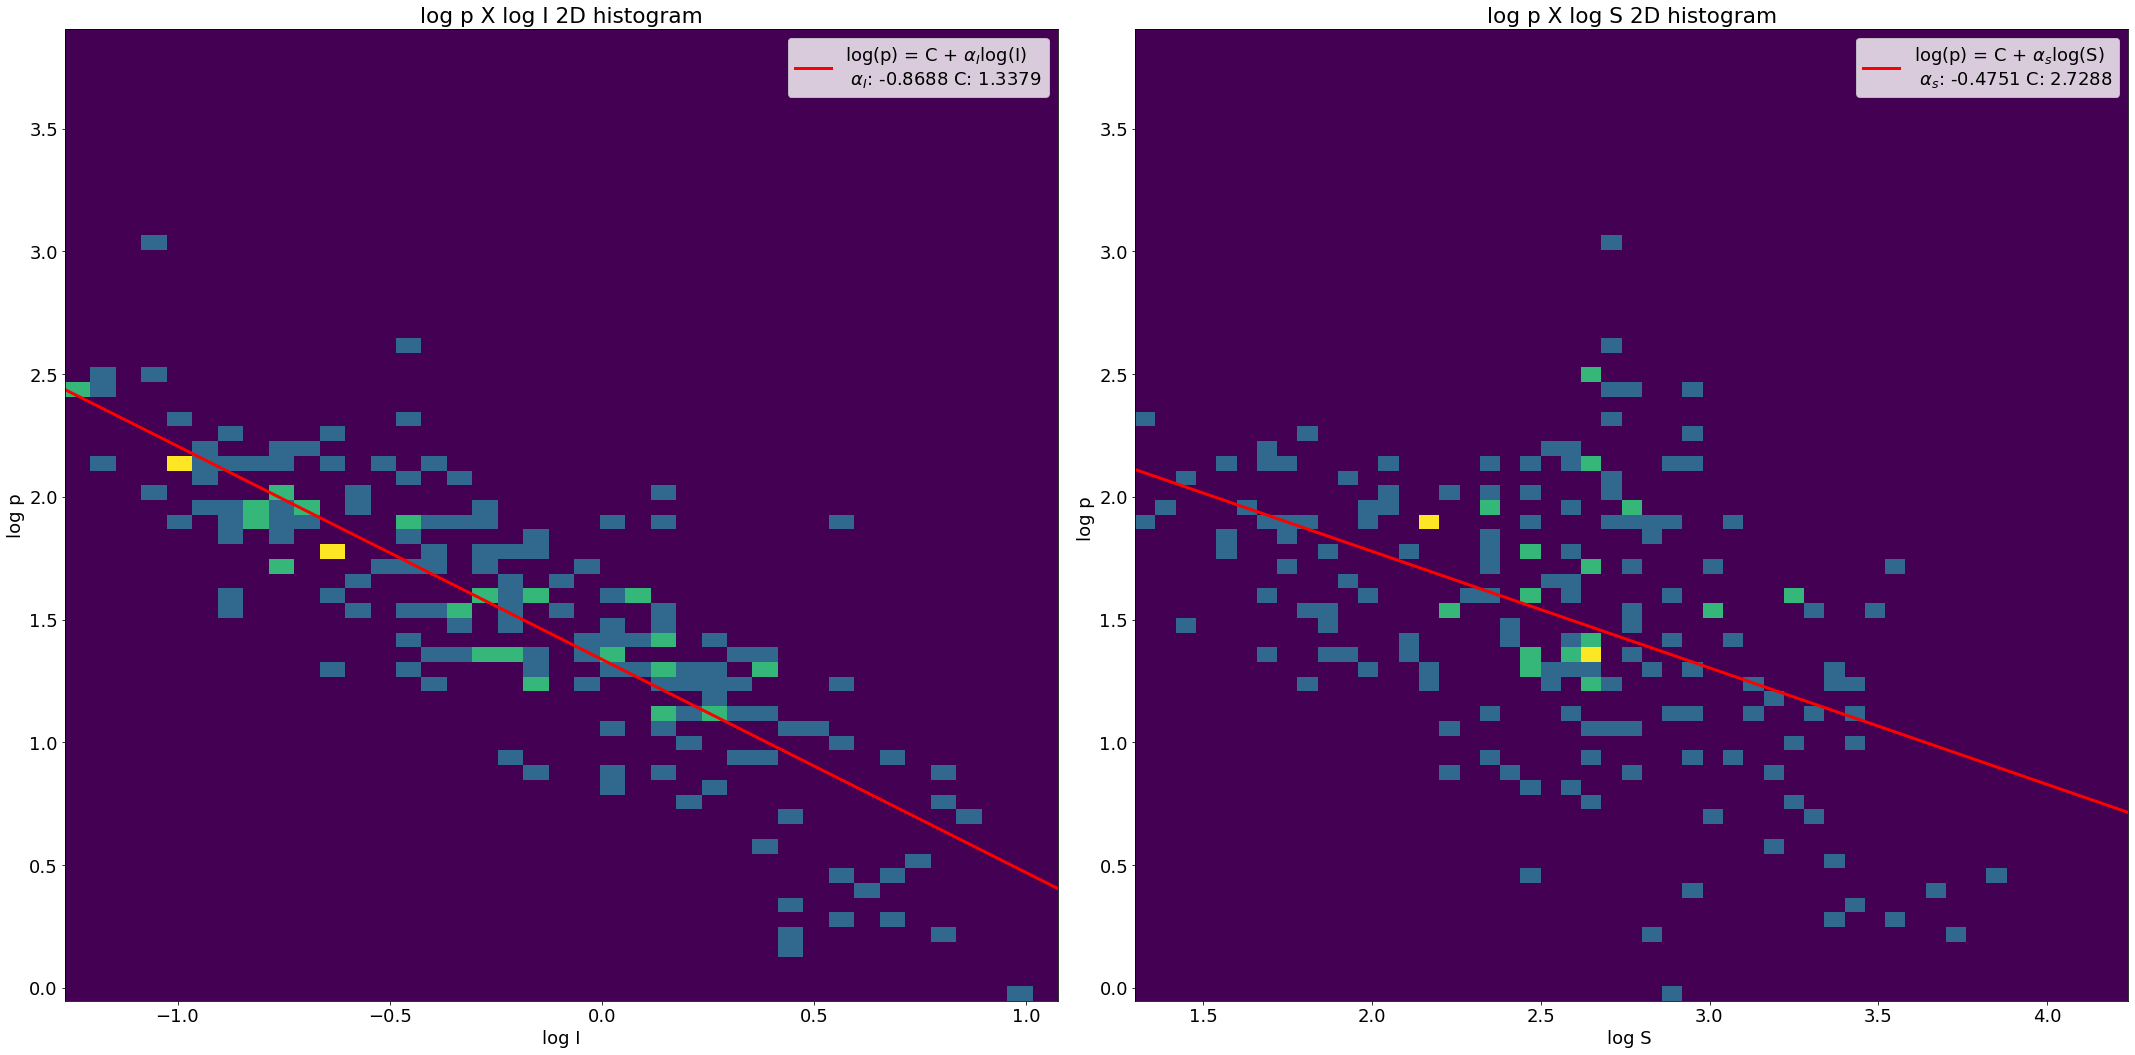

C : 2.020554424197897
s index : -0.2600838753099747
p index : -0.7919376474288772


In [183]:
def lin_fit(x, a, b):
    return a + b*x

s_fill_right_array = s_fil_right.data.flatten()
p_fill_right_array = p_fil_right.data.flatten()
I_fill_right_array = I_fil_right.data.flatten()

s_fill_right_array_ind = s_fill_right_array.copy()
s_fill_right_array_ind = s_fill_right_array_ind[::4]
p_fill_right_array_ind = p_fill_right_array.copy()
p_fill_right_array_ind = p_fill_right_array_ind[::4]
I_fill_right_array_ind = I_fill_right_array.copy()
I_fill_right_array_ind = I_fill_right_array_ind[::4]


log_s = np.log(s_fill_right_array_ind)
log_p = np.log(p_fill_right_array_ind)
log_I = np.log(I_fill_right_array_ind)


p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
  

p_bins = np.arange(p_min, p_max, 0.06)
s_bins = np.arange(s_min, s_max, 0.06)
I_bins = np.arange(I_min, I_max, 0.06)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
df_log = df_log.dropna()

PS_right_fil_param, PS_right_fil_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_right_fil = lin_fit(s_bins,PS_right_fil_param[0],PS_right_fil_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_right_fil_param, PI_right_fil_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_right_fil = lin_fit(I_bins,PI_right_fil_param[0],PI_right_fil_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

fig = plt.subplots(figsize =(30, 15))
ax1 = plt.subplot(122)
ax1.hist2d(log_s,log_p,bins =[s_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_right_fil_param[1],C = PS_right_fil_param[0],linebreak='\n')
plt.plot(s_bins,PS_FitFunc_right_fil,'r',linewidth=3,label = label_temp)
ax1.set_title("log p X log S 2D histogram")
ax1.set_ylabel('log p ')
ax1.set_xlabel('log S ')
# ax1.set_xlim(-1,5,5)
# ax1.set_ylim(-2.5,4)
ax2 = plt.subplot(121)
ax2.hist2d(log_I,log_p,bins =[I_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_right_fil_param[1],C = PI_right_fil_param[0],linebreak='\n')
ax2.plot(I_bins,PI_FitFunc_right_fil,'r',linewidth=3,label = label_temp)
ax2.set_title("log p X log I 2D histogram")
ax2.set_ylabel('log p')
ax2.set_xlabel('log I')
# ax2.set_xlim(-1,5,5)
# ax2.set_ylim(-2.5,4)
plt.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.5539, -0.2614, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('p index :',PSI_param_lower[2])

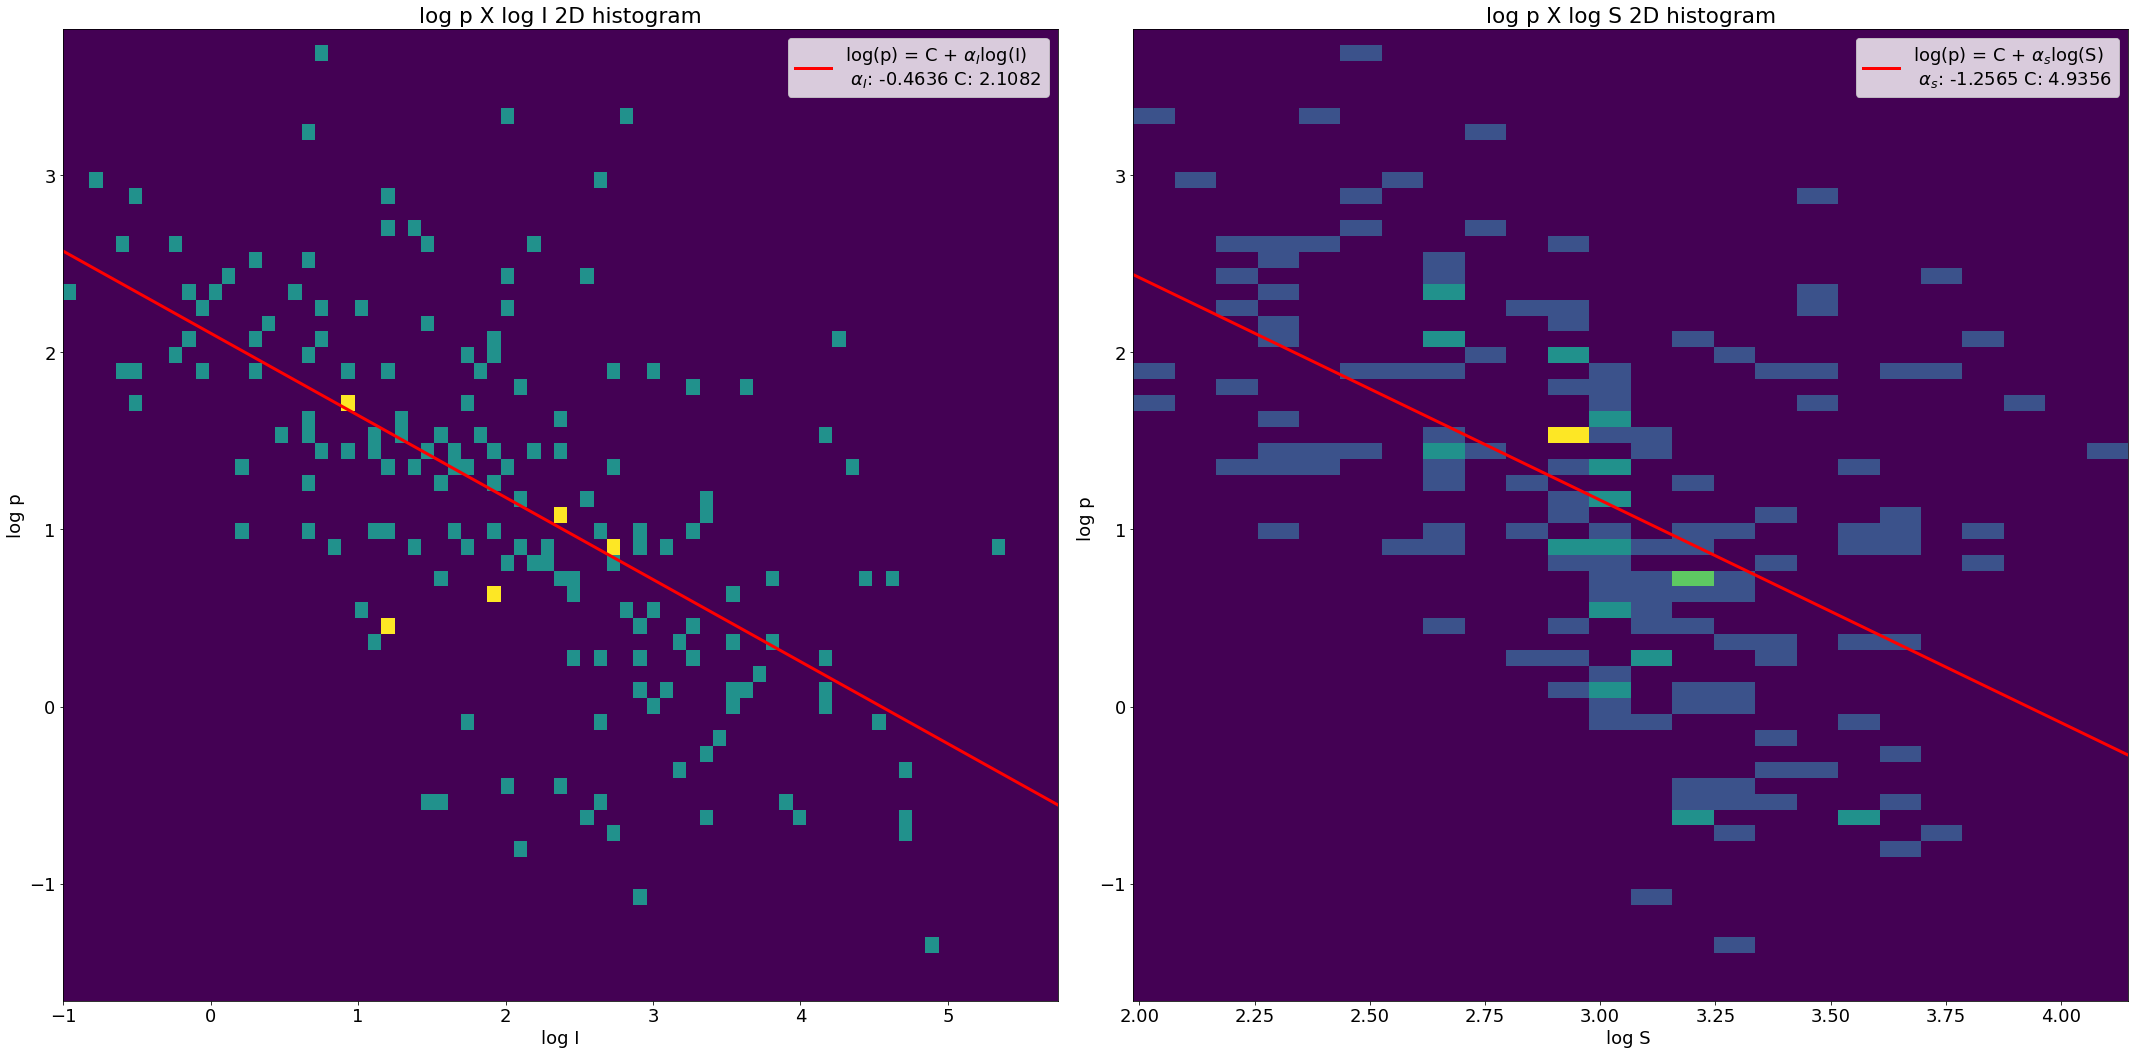

C : 4.869232207013746
s index : -0.970706829550112
p index : -0.38684990939180497


In [182]:
def lin_fit(x, a, b):
    return a + b*x

s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
I_ridge_array = I_ridge.data.flatten()

s_ridge_array_ind = s_ridge_array.copy()
s_ridge_array_ind = s_ridge_array_ind[::4]
p_ridge_array_ind = p_ridge_array.copy()
p_ridge_array_ind = p_ridge_array_ind[::4]
I_ridge_array_ind = I_ridge_array.copy()
I_ridge_array_ind = I_ridge_array_ind[::4]


log_s = np.log(s_ridge_array_ind)
log_p = np.log(p_ridge_array_ind)
log_I = np.log(I_ridge_array_ind)


p_min = np.nanmin(log_p)
p_max = np.log(50)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
  

p_bins = np.arange(p_min, p_max, 0.09)
s_bins = np.arange(s_min, s_max, 0.09)
I_bins = np.arange(I_min, I_max, 0.09)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I})
df_log = df_log.dropna()

PS_ridge_param, PS_ridge_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_ridge = lin_fit(s_bins,PS_ridge_param[0],PS_ridge_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_ridge_param, PI_ridge_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_ridge = lin_fit(I_bins,PI_ridge_param[0],PI_ridge_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

fig = plt.subplots(figsize =(30, 15))
ax1 = plt.subplot(122)
ax1.hist2d(log_s,log_p,bins =[s_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
plt.plot(s_bins,PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax1.set_title("log p X log S 2D histogram")
ax1.set_ylabel('log p ')
ax1.set_xlabel('log S ')
# ax1.set_xlim(-1,5,5)
# ax1.set_ylim(-2.5,4)
ax2 = plt.subplot(121)
ax2.hist2d(log_I,log_p,bins =[I_bins, p_bins])
label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax2.set_title("log p X log I 2D histogram")
ax2.set_ylabel('log p')
ax2.set_xlabel('log I')
# ax2.set_xlim(-1,5,5)
# ax2.set_ylim(-2.5,4)
plt.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

p0 = -0.5539, -0.2614, 2.
PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
print('C :',PSI_param_lower[0])
print('s index :',PSI_param_lower[1])
print('p index :',PSI_param_lower[2])